<a href="https://colab.research.google.com/github/navyakarna/PYTORCH_CV/blob/main/AlexNet_on_HUman_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

8 layers ,
image size it could process is larger - 227X227
pooling - maxpooling
padding - yes
activation function - RELU
Dropout - 50%

In [1]:
import os
import torch
from torchvision import transforms , datasets
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

In [4]:
from zipfile import ZipFile

# Specify the path to your zip file
zip_file_path = '/content/Archive.zip'

# Specify the directory where you want to extract the contents
extract_to_path = '/content/'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_to_path)

print(f"Extracted files to {extract_to_path}")

Extracted files to /content/


In [5]:
#paths to the data

train_data_path = r'/content/Human Action Recognition/test'
test_data_path = r'/content/Human Action Recognition/test'

In [6]:
#apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=transforms)
test_data = datasets.ImageFolder(root=test_data_path, transform=transforms)

In [7]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class AlexNet(nn.Module):
  def __init__(self, num_classes=5):
    super(AlexNet, self).__init__()  # Add super().__init__() call
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), # Corrected kernel_sie to kernel_size
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(64, 192, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(192, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2)
    )


    self.fc_input_dim = 256*6*6 #calaculate the size of the feature map after the last ReLu function

    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(self.fc_input_dim, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),


    )



  def forward(self, x): # Corrected indentation for forward method
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x





In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cpu')

In [10]:
import torch.optim as optim
model = AlexNet()

#define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimier = optim.Adam(model.parameters())

In [17]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader # Import DataLoader

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Define batch size
batch_size = 32  # You can adjust this value

# Create data loaders
train_data = datasets.ImageFolder(root=train_data_path, transform=transform) # Use the 'transform' object
test_data = datasets.ImageFolder(root=test_data_path, transform=transform) # Use the 'transform' object
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimier.zero_grad() # Use the defined optimizer name 'optimier'
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimier.step() # Use the defined optimizer name 'optimier'
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # The line below is causing the error. It's not clear what 'sample' is
        # supposed to be here, and 'self.transform' is not defined in this scope.
        # If you intended to apply a transformation, 'transform' is already
        # applied when creating the DataLoader with the ImageFolder dataset.
        # sample = transform(sample)  # Removed the problematic line

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Epoch [1/20], Train Loss: 1.8155, Train Accuracy: 16.83%
Test Loss: 1.6086, Test Accuracy: 19.84%
Updated best model with accuracy: 19.84%


100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


Epoch [2/20], Train Loss: 1.6108, Train Accuracy: 20.95%
Test Loss: 1.6043, Test Accuracy: 24.13%
Updated best model with accuracy: 24.13%


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Epoch [3/20], Train Loss: 1.6007, Train Accuracy: 24.92%
Test Loss: 1.5545, Test Accuracy: 29.37%
Updated best model with accuracy: 29.37%


100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Epoch [4/20], Train Loss: 1.5682, Train Accuracy: 27.46%
Test Loss: 1.5534, Test Accuracy: 34.44%
Updated best model with accuracy: 34.44%


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Epoch [5/20], Train Loss: 1.5381, Train Accuracy: 32.54%
Test Loss: 1.5233, Test Accuracy: 31.59%
Updated best model with accuracy: 31.59%


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Epoch [6/20], Train Loss: 1.5162, Train Accuracy: 32.38%
Test Loss: 1.4658, Test Accuracy: 34.92%
Updated best model with accuracy: 34.92%


100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


Epoch [7/20], Train Loss: 1.5165, Train Accuracy: 31.59%
Test Loss: 1.5588, Test Accuracy: 28.41%


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch [8/20], Train Loss: 1.5276, Train Accuracy: 28.73%
Test Loss: 1.4748, Test Accuracy: 36.35%


100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


Epoch [9/20], Train Loss: 1.4691, Train Accuracy: 39.84%
Test Loss: 1.5147, Test Accuracy: 30.00%


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Epoch [10/20], Train Loss: 1.4567, Train Accuracy: 37.62%
Test Loss: 1.3935, Test Accuracy: 42.86%
Updated best model with accuracy: 42.86%


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Epoch [11/20], Train Loss: 1.3999, Train Accuracy: 40.16%
Test Loss: 1.3221, Test Accuracy: 46.19%
Updated best model with accuracy: 46.19%


100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Epoch [12/20], Train Loss: 1.4074, Train Accuracy: 40.32%
Test Loss: 1.3080, Test Accuracy: 47.30%
Updated best model with accuracy: 47.30%


100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


Epoch [13/20], Train Loss: 1.3910, Train Accuracy: 43.02%
Test Loss: 1.3526, Test Accuracy: 43.02%


100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch [14/20], Train Loss: 1.3723, Train Accuracy: 41.43%
Test Loss: 1.3298, Test Accuracy: 47.46%


100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


Epoch [15/20], Train Loss: 1.3725, Train Accuracy: 42.70%
Test Loss: 1.2884, Test Accuracy: 45.24%
Updated best model with accuracy: 45.24%


100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Epoch [16/20], Train Loss: 1.3219, Train Accuracy: 45.87%
Test Loss: 1.2329, Test Accuracy: 48.57%
Updated best model with accuracy: 48.57%


100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Epoch [17/20], Train Loss: 1.2772, Train Accuracy: 45.08%
Test Loss: 1.1123, Test Accuracy: 54.92%
Updated best model with accuracy: 54.92%


100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Epoch [18/20], Train Loss: 1.1876, Train Accuracy: 49.05%
Test Loss: 1.1551, Test Accuracy: 51.75%


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Epoch [19/20], Train Loss: 1.1742, Train Accuracy: 52.38%
Test Loss: 1.1023, Test Accuracy: 60.16%
Updated best model with accuracy: 60.16%


100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch [20/20], Train Loss: 1.1243, Train Accuracy: 53.97%
Test Loss: 0.9556, Test Accuracy: 64.44%
Updated best model with accuracy: 64.44%


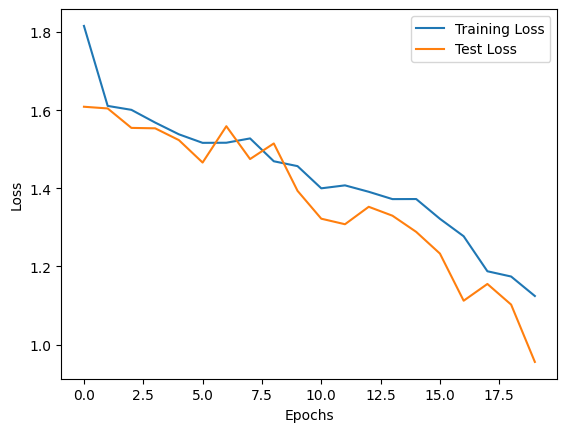

In [18]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()